# Stream detection using the Chen+25 method

In this example, we apply the Chen+25 method to detect a stream in a mock dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.coordinates as coord
import agama

from StarStream import calc_prog_frame, GaiaStreamFromProgPDF, GaiaBackgroundPDF, optimize_mle

# isochrones is just for this notebook, not the package
from isochrones.mist import MIST_Isochrone 
mist = MIST_Isochrone()

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Load mock dataset

The code to generate the mock dataset is `make_mock.ipynb`. Please run it first before loading.

In [2]:
dataset = np.loadtxt("data/mock_dataset.txt")
data_all = dataset[:,0:6]
err_all = dataset[:,6:12]
label_all = dataset[:,12].astype(bool)

## Spatial and magnitude ranges to find streams

In [3]:
field_range = (-10.0, 10.0) # spatial range in deg
mag_cut = 20.0 # magnitude cut
mag_range = (15.0, mag_cut) # magnitude range

## Known parameters

We need to know some parameters of the toy Galaxy and GC ahead of time.

In [4]:
pot = agama.Potential("data/MWPotential2014.ini")

mass_gc = 1e5 # Msun
coord_gc = coord.Galactocentric(
    x=0.0*u.kpc,
    y=10.0*u.kpc,
    z=10.0*u.kpc,
    v_x=-100.0*u.km/u.s,
    v_y=0.0*u.km/u.s,
    v_z=-150.0*u.km/u.s
)
age = 10.0 # Gyr
feh = -1.0

skycoord_gc = coord_gc.transform_to(coord.ICRS())
frame = calc_prog_frame(skycoord_gc)

iso = mist.isochrone(age=age, feh=feh) # if you never run this before, it'll take a while
iso_mini = iso["initial_mass"]
iso_color = iso["BP_mag"] - iso["RP_mag"]
iso_mag = iso["G_mag"]

## Next, let's find streams using the mixture model

### Construct PDFs for the stream and background

In [5]:
# construct PDFs using the same method in Chen+25

t_tot = 1.0 # Gyr
n_steps = 500
seed = 24 # use a different seed to make sure our success is not from luck

# stream PDF using particle spray from progenitor GC
pdf_stream = GaiaStreamFromProgPDF(
    pot, mass_gc, coord_gc, iso_mini, iso_color, iso_mag, 
    mag_cut=mag_cut, frame=frame, t_tot=t_tot, n_steps=n_steps, seed=seed
)

# background PDF from observed satrs
pdf_bg = GaiaBackgroundPDF(data_all, field_range=field_range, mag_cut=mag_cut, seed=seed)

998 orbits complete (1.883e+04 orbits/s)


### Estimate best-fit stream fraction using MLE

In [6]:
fbest, prob, frac_list, dlnL_list = optimize_mle(data_all, err_all, pdf_stream, pdf_bg)

print(f"The best-fit stream fraction from MLE is {fbest:.2e}")

The best-fit stream fraction from MLE is 1.58e-03


### Detection result

In [7]:
pth = 0.4 # threshold probability

mask_correct = (prob > pth) & label_all
print(f"Correct detection: {np.sum(mask_correct)}")

mask_missing = (prob <= pth) & label_all
print(f"Missing stars: {np.sum(mask_missing)}")

mask_false = (prob > pth) & ~label_all
print(f"False positives: {np.sum(mask_false)}")

Correct detection: 135
Missing stars: 34
False positives: 30


### Some visualizations of the detection

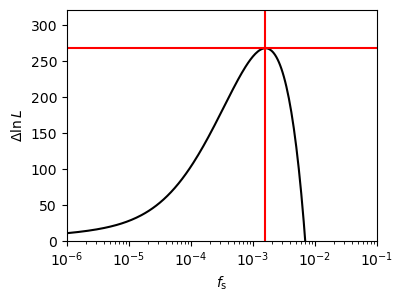

In [8]:
fig, ax0 = plt.subplots(1, 1, figsize=(4,3))

ax0.plot(frac_list, dlnL_list, c="k")

ax0.axvline(fbest, c="r")
ax0.axhline(np.max(dlnL_list), c="r")

ax0.set_xlabel(r"$f_{\rm s}$")
ax0.set_ylabel(r"$\Delta \ln L$")
ax0.set_xscale("log")
ax0.set_xlim(1e-6,1e-1)
ax0.set_ylim(0,np.max(dlnL_list)*1.2)

plt.show()

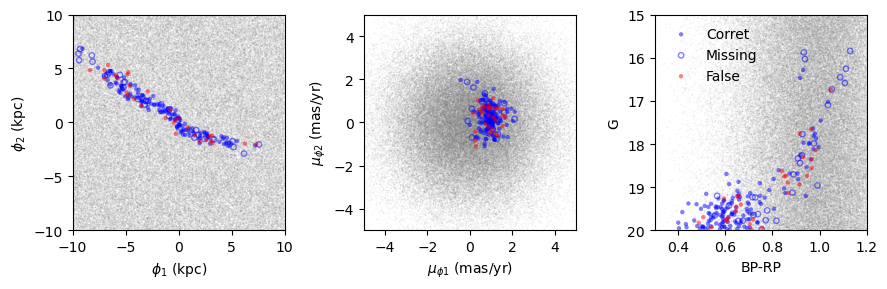

In [9]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(9,3))

ax0.scatter(data_all[:,0], data_all[:,1], fc="gray", ec="None", s=1, alpha=0.1)
ax1.scatter(data_all[:,2], data_all[:,3], fc="gray", ec="None", s=1, alpha=0.1)
ax2.scatter(data_all[:,4], data_all[:,5], fc="gray", ec="None", s=1, alpha=0.1)

ax0.scatter(data_all[mask_correct,0], data_all[mask_correct,1], fc="b", ec="None", s=10, alpha=0.5)
ax1.scatter(data_all[mask_correct,2], data_all[mask_correct,3], fc="b", ec="None", s=10, alpha=0.5)
ax2.scatter(data_all[mask_correct,4], data_all[mask_correct,5], fc="b", ec="None", s=10, alpha=0.5, label=r"Corret")

ax0.scatter(data_all[mask_missing,0], data_all[mask_missing,1], ec="b", fc="None", s=15, alpha=0.5)
ax1.scatter(data_all[mask_missing,2], data_all[mask_missing,3], ec="b", fc="None", s=15, alpha=0.5)
ax2.scatter(data_all[mask_missing,4], data_all[mask_missing,5], ec="b", fc="None", s=15, alpha=0.5, label=r"Missing")

ax0.scatter(data_all[mask_false,0], data_all[mask_false,1], fc="r", ec="None", s=10, alpha=0.5)
ax1.scatter(data_all[mask_false,2], data_all[mask_false,3], fc="r", ec="None", s=10, alpha=0.5)
ax2.scatter(data_all[mask_false,4], data_all[mask_false,5], fc="r", ec="None", s=10, alpha=0.5, label=r"False")

ax2.legend(loc="upper left", frameon=False)

ax0.set_xlabel(r"$\phi_1$ (kpc)")
ax0.set_ylabel(r"$\phi_2$ (kpc)")
ax1.set_xlabel(r"$\mu_{\phi1}$ (mas/yr)")
ax1.set_ylabel(r"$\mu_{\phi2}$ (mas/yr)")
ax2.set_xlabel(r"BP-RP")
ax2.set_ylabel(r"G")

ax0.set_xlim(*field_range)
ax0.set_ylim(*field_range)
ax1.set_xlim(-5.0,5.0)
ax1.set_ylim(-5.0,5.0)
ax2.set_xlim(0.3,1.2)
ax2.set_ylim(mag_range[1],mag_range[0])

plt.tight_layout()
plt.show()